In [2]:
# Setting up inputs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from itertools import groupby
from operator import itemgetter

# Imports neccessary for ODE setup
from scipy.integrate import odeint
from scipy.optimize import least_squares
from numpy.linalg import inv

bg TC time data 0     0.0
1     0.5
2     1.0
3     1.5
4     2.0
5     2.5
6     3.0
7     3.5
8     4.0
9     4.5
10    5.0
11    5.5
12    6.0
13    6.5
14    7.0
15    7.5
16    8.0
17    8.5
18    9.0
19    9.5
Name: elapsed time (min), dtype: float64
sample TC time data 0     0.0
1     0.5
2     1.0
3     1.5
4     2.0
5     2.5
6     3.0
7     3.5
8     4.0
9     4.5
10    5.0
11    5.5
12    6.0
13    6.5
14    7.0
15    7.5
16    8.0
17    8.5
18    9.0
19    9.5
Name: elapsed time (min), dtype: float64


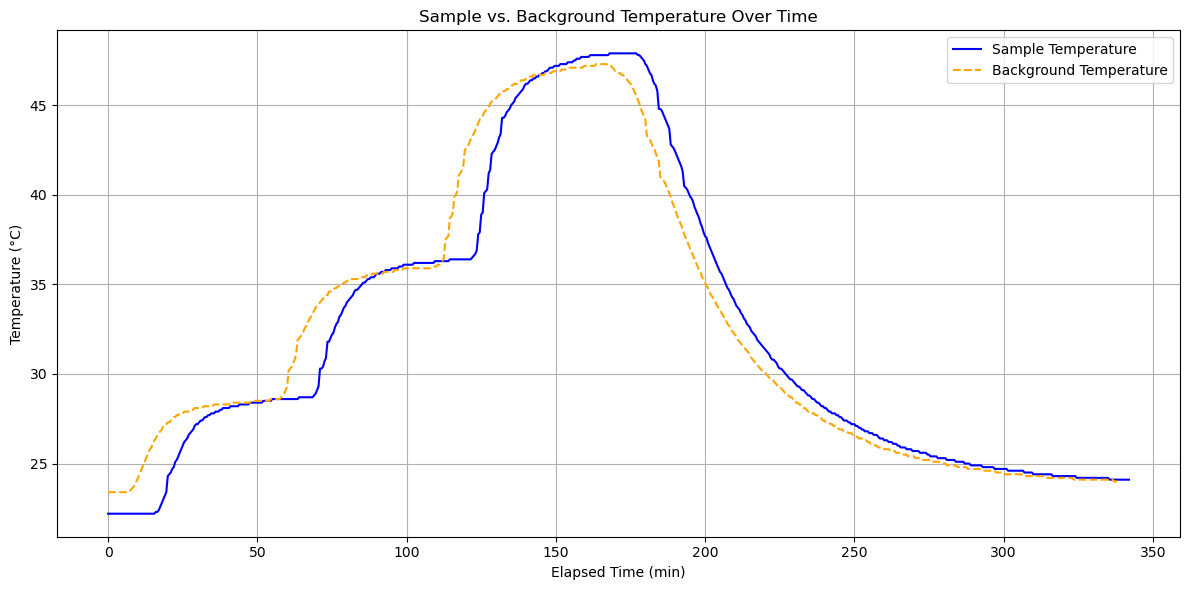

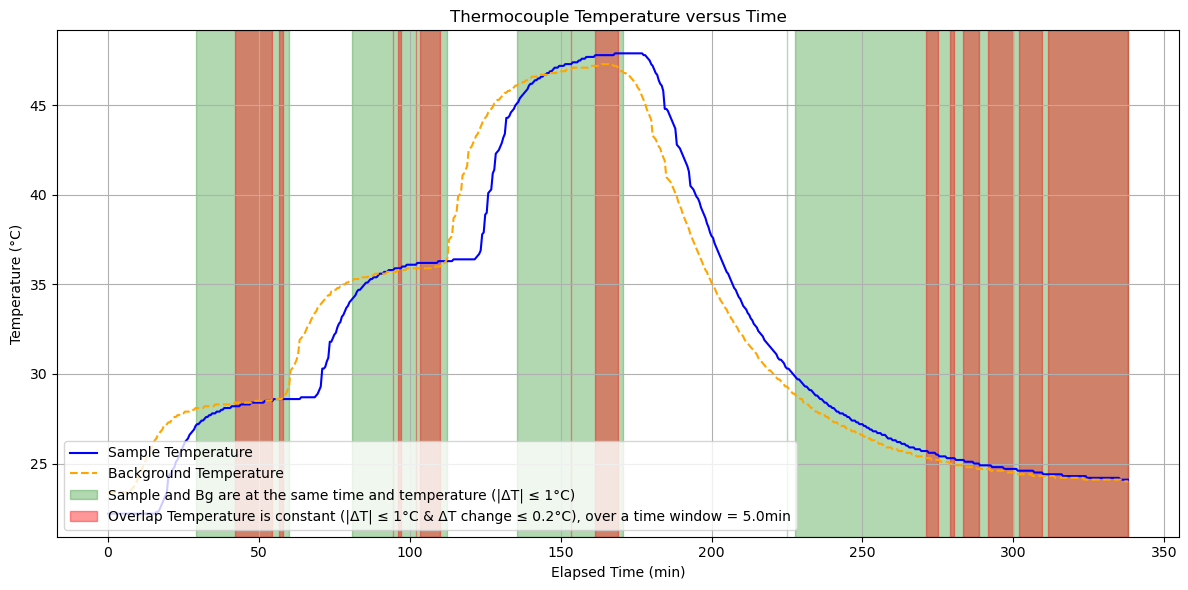

In [3]:
# Time series analysis, find overlapping temperature times, then find constant temperature within those overlapping intervals

# Load in the data
temp_data = pd.read_csv('sample_TD.csv', encoding='utf-16', delimiter='\t')
temp_bg = pd.read_csv('bg_thermo_data.csv', encoding='utf-16', delimiter='\t')

temp_data = temp_data.rename(columns={'°C.1': 'Canister C'}) # renaming columns for ease
temp_bg = temp_bg.rename(columns={'°C.1': 'Canister C'})

temp_range_data = temp_data['Canister C'] # temperature range is just the internal canister temperature

start_idx = temp_bg[temp_bg['Time'] == '16:44:26'].index[0] # TC data starts before vocus data, filter TC so it aligns with Vocus tseries
temp_bg = temp_bg.iloc[start_idx:].reset_index(drop=True) # Drop all rows after this index, keep index
temp_range_bg = temp_bg['Canister C']

temp_data['elapsed time (min)'] = np.arange(len(temp_data['Time'])) * 30 / 60  # increases by 30 seconds, in minutes
temp_bg['elapsed time (min)'] = np.arange(len(temp_bg['Time'])) * 30 / 60  # increases by 30 seconds, in minutes

time_range_data = temp_data['elapsed time (min)'] # select Time range (elapsed time)
time_range_bg = temp_bg['elapsed time (min)']

print(f'bg TC time data {time_range_bg.head(20)}')
print(f'sample TC time data {time_range_data.head(20)}')


# Plotting both bg and sample temperature ranges against elapsed time
plt.figure(figsize=(12, 6))
plt.plot(time_range_data, temp_range_data, label='Sample Temperature', color='blue')
plt.plot(time_range_bg, temp_range_bg, label='Background Temperature', color='orange', linestyle='--')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Sample vs. Background Temperature Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Find overlapping intervals where bg and sample are at the same temperature and time (within a tolerance)
min_len = min(len(temp_range_data), len(temp_range_bg)) # Align lengths
temp_data_aligned = temp_range_data.iloc[:min_len].reset_index(drop=True)
temp_bg_aligned = temp_range_bg.iloc[:min_len].reset_index(drop=True)
time_aligned = time_range_data.iloc[:min_len].reset_index(drop=True)

tolerance = 1 # within 1 degree C temperature variance
matches = (np.abs(temp_data_aligned - temp_bg_aligned) <= tolerance) # Absolute value points where temperature difference is within tolerance

indices = matches[matches].index.tolist() # filters for matches (within tolerance) and gives their corresponding elapsed time
intervals = [] # loop through all of the matches
for k, g in groupby(enumerate(indices), lambda ix: ix[0] - ix[1]): # find the difference between indices to group consecutive ones
    group = list(map(itemgetter(1), g)) # get the actual indices
    intervals.append((group[0], group[-1])) # start and end of each interval

# Find points within the overlap where temperature is constant
window = 10 # Window = number of data points, window * 30s = minutes
fluctuation_tol = 0.2 # Fluctuation in temperature tolerance

# Calculate the different between the highets and lowest temperature within the specific window range
rolling_sample = temp_data_aligned.rolling(window).apply(lambda x: x.max() - x.min(), raw=True).fillna(200) # fake large to not pass stability test, aka fullw indow must exist for stability test
rolling_bg = temp_bg_aligned.rolling(window).apply(lambda x: x.max() - x.min(), raw=True).fillna(200)

stable_fluctuation = (rolling_sample <= fluctuation_tol) & (rolling_bg <= fluctuation_tol) # Keep the range if the rolling value is below the fluctuation tolerance

stable_overlap = matches & stable_fluctuation # make sure the stable fluctuations are within the matches

indices_stable = stable_overlap[stable_overlap].index.tolist() # filters for matches (within tolerance) and gives their corresponding elapsed time
intervals_stable = [] # loop through all of the matches
for k, g in groupby(enumerate(indices_stable), lambda ix: ix[0] - ix[1]): # find the difference between indices to group consecutive ones
    group = list(map(itemgetter(1), g)) # get the actual indices
    intervals_stable.append((group[0], group[-1])) # start and end of each interval

# Plot intervals
plt.figure(figsize=(12, 6))
plt.plot(time_aligned, temp_data_aligned, label='Sample Temperature', color='blue')
plt.plot(time_aligned, temp_bg_aligned, label='Background Temperature', color='orange', linestyle='--')
for start, end in intervals:
    plt.axvspan(time_aligned[start], time_aligned[end], color='green', alpha=0.3, label='Sample and Bg are at the same time and temperature (|ΔT| ≤ 1°C)')
for start, end in intervals_stable:
    plt.axvspan(time_aligned[start], time_aligned[end], color='red', alpha=0.4, label=f'Overlap Temperature is constant (|ΔT| ≤ {tolerance}°C & ΔT change ≤ {fluctuation_tol}°C), over a time window = {window * 0.5}min')

plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Thermocouple Temperature versus Time')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.grid(True)
plt.tight_layout()
plt.show()

'''
# Print the time-temp agreement intervals and the constant temperature intervals
for start, end in intervals: # same time and temp within threshold
    print(f"Overlap from {time_aligned[start]:.2f} min to {time_aligned[end]:.2f} min (duration: {time_aligned[end]-time_aligned[start]:.2f} min)")
for start, end in intervals_stable: # same time and temp within threshold, temp constant
    print(f"Stable Overlap from {time_aligned[start]:.2f} min to {time_aligned[end]:.2f} min "
          f"(duration: {time_aligned[end]-time_aligned[start]:.2f} min) | "
          f"Sample Temp: {temp_data_aligned[start]:.2f}-{temp_data_aligned[end]:.2f} °C | "
          f"Background Temp: {temp_bg_aligned[start]:.2f}-{temp_bg_aligned[end]:.2f} °C")
'''

# Create dataframe for temperature and times within the threshold
overlap_rows = []
for start, end in intervals:
    for i in range(start, end + 1):
        overlap_rows.append({'elapsed time (min)': time_aligned[i],'sample temperature': temp_data_aligned[i],'bg temperature': temp_bg_aligned[i]})
overlapping_intervals = pd.DataFrame(overlap_rows)
# print(f'overlap {overlapping_intervals["elapsed time (min)"]}')

# Create dataframe for constant temperature intervals within overlapping intervals
constant_temp_rows = []
for start, end in intervals_stable:
    for i in range(start, end + 1):
        constant_temp_rows.append({'elapsed time (min)': time_aligned[i],'sample temperature': temp_data_aligned[i],'bg temperature': temp_bg_aligned[i]})
constant_temp_intervals = pd.DataFrame(constant_temp_rows)
# print(constant_temp_intervals.head(30))

In [ ]:
# Convert Vocus time series data and then Filter  by Thermocouple overlap periods
vocus_sample_tseries = pd.read_csv('sample_tseries.csv', delimiter=',', names=['date'], header=None) # import vocus sample tseries data, add column title
vocus_bg_tseries = pd.read_csv('background_tseries.csv', delimiter=',', names=['date'], header=None) # import vocus bg tseries data, add column title

# print(vocus_sample_tseries.head())
# print(vocus_bg_tseries.head())

# Filter vocus time series' to match when TC was on
vocus_sample_tseries['date'] = pd.to_datetime(vocus_sample_tseries['date'].astype(str), errors='coerce')
vocus_bg_tseries['date'] = pd.to_datetime(vocus_bg_tseries['date'].astype(str), errors='coerce')

s_start_time = pd.to_datetime('2025-06-05 01:05:53.9') # When TC was on for sample run
s_end_time = pd.to_datetime('2025-06-05 06:47:48.0') # When TC was off for sample run
b_start_time = pd.to_datetime('2025-06-03 23:44:18') # When TC was on for bg run
b_end_time = pd.to_datetime('2025-06-04 05:31:23') # When TC was off for bg run

f_vocus_sample_tseries = vocus_sample_tseries[(vocus_sample_tseries['date'] >= s_start_time) &(vocus_sample_tseries['date'] <= s_end_time)].reset_index(drop=True) # Filter sample vocus tseries by TC range
f_vocus_bg_tseries = vocus_bg_tseries[(vocus_bg_tseries['date'] >= b_start_time) &(vocus_bg_tseries['date'] <= b_end_time)].reset_index(drop=True) # Filter bg vocus tseries by TC range

# print(f_vocus_sample_tseries.head(10))
# print(f_vocus_bg_tseries.head(10))

# Convert Vocus time series data to elapse over 30 seconds
n = 3 # How many rows to group together (3, 10s rows = 30s time interval)
s_df_30s = (f_vocus_sample_tseries.groupby(np.arange(len(f_vocus_sample_tseries)) // n, as_index=False).mean(numeric_only=True)) # group all of the rows by 3, get an average time (+0.5)
bg_df_30s = (f_vocus_bg_tseries.groupby(np.arange(len(f_vocus_bg_tseries)) // n, as_index=False).mean(numeric_only=True))

s_df_30s['date'] = f_vocus_sample_tseries['date'].iloc[::n].reset_index(drop=True) # take the corresponding time step for each bin
bg_df_30s['date'] = f_vocus_bg_tseries['date'].iloc[::n].reset_index(drop=True)

s_df_30s['elapsed time (min)'] = np.arange(len(s_df_30s)) * (n * 10) / 60 # calculate elapsed time (30s intervals)
bg_df_30s['elapsed time (min)'] = (np.arange(len(bg_df_30s)) * (n * 10) / 60)

# Filter 30s data by the overlap range from the thermalcouple data
s_f_tseries = s_df_30s[s_df_30s['elapsed time (min)'].isin(overlapping_intervals['elapsed time (min)'])]
bg_f_tseries = bg_df_30s[bg_df_30s['elapsed time (min)'].isin(overlapping_intervals['elapsed time (min)'])]

# For acetone norm only
not_coupled_s_df_30s = (vocus_sample_tseries.groupby(np.arange(len(vocus_sample_tseries)) // n, as_index=False).mean(numeric_only=True)) # NOT FILTERED group all of the rows by 3, get an average time (+0.5)
not_coupled_bg_df_30s = (vocus_bg_tseries.groupby(np.arange(len(vocus_bg_tseries)) // n, as_index=False).mean(numeric_only=True))

not_coupled_s_df_30s['date'] = vocus_sample_tseries['date'].iloc[::n].reset_index(drop=True) # take the corresponding time step for each bin
not_coupled_bg_df_30s['date'] = vocus_bg_tseries['date'].iloc[::n].reset_index(drop=True)

not_coupled_s_df_30s['elapsed time (min)'] = np.arange(len(not_coupled_s_df_30s)) * (n * 10) / 60 # calculate elapsed time (30s intervals)
not_coupled_bg_df_30s['elapsed time (min)'] = (np.arange(len(not_coupled_bg_df_30s)) * (n * 10) / 60)

# print(f'filtered 10s sample tsteries {f_vocus_sample_tseries.head(20)}')
# print(f'number of 10s rows {len(f_vocus_sample_tseries)}')
# print(f'30s sample df {s_df_30s['elapsed time (min)'].head(15)}') # print first 10 rows filtered 30s tseries
# print(f'number of 30s rows {len(s_df_30s)}')
# print(f'filtered 10s bg tsteries {f_vocus_bg_tseries.head(20)}')
# print(f'number of 10s bg rows {len(f_vocus_bg_tseries)}')
# print(f'30s bg df {bg_df_30s['elapsed time (min)'].head(15)}') # print first 10 rows of filtered 30s tseries
# print(f'number of bg 30s rows {len(bg_df_30s)}')
# print(f'number of vocus tseries 10s not filtered bg {len(vocus_bg_tseries)}')
# print(f'vocus tseries 30s not filtered bg {vocus_bg_tseries.head(20)}')
# print(f'number of vocus tseries 30s not filtered samp {len(not_coupled_s_df_30s)}')
# print(f'vocus bg tseries 30s head {not_coupled_bg_df_30s['elapsed time (min)'].head(15)}')

# print(f'overlapping intervals {overlapping_intervals['elapsed time (min)']}')
# print(f'filter s attempt {s_f_tseries}')
# print(f'filter bg attempt {bg_f_tseries}')

# print(s_f_tseries.columns)


number of 30s rows 684
number of vocus tseries 30s not filtered samp 723


C:\Users\rebek\AppData\Local\Temp\ipykernel_5408\109292800.py:25: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  s_df_30s = (f_vocus_sample_tseries.groupby(np.arange(len(f_vocus_sample_tseries)) // n, as_index=False).mean(numeric_only=True)) # group all of the rows by 3, get an average time (+0.5)
C:\Users\rebek\AppData\Local\Temp\ipykernel_5408\109292800.py:26: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  bg_df_30s = (f_vocus_bg_tseries.groupby(np.arange(len(f_vocus_bg_tseries)) // n, as_index=False).mean(numeric_only=True))
C:\Users\rebek\AppData\Local\Temp\ipykernel_5408\109292800

In [42]:
# Convert vocus signal data and filter by thermocouple overlap times

# Load in .csv
vocus_sample = pd.read_csv('Raw_Mx_data.csv') # import sample signal data
vocus_bg = pd.read_csv('background_Mx_data_HR.csv') # import background signal data

# Filter vocus sample/bg signal data to the same time range as the vocus tseries
mask_s = (vocus_sample_tseries['date'] >= s_start_time) & (vocus_sample_tseries['date'] <= s_end_time) # filter by the same time range
mask_bg = (vocus_bg_tseries['date'] >= b_start_time) & (vocus_bg_tseries['date'] <= b_end_time) # filter by the same time range

filtered_indices_s = vocus_sample_tseries[mask_s].index # use indices versus actual dates
filtered_indices_bg = vocus_bg_tseries[mask_bg].index # use indices versus actual dates

filtered_vocus_sample = vocus_sample.loc[filtered_indices_s].reset_index(drop=True) # filter vocus data by indices
filtered_vocus_bg = vocus_bg.loc[filtered_indices_bg].reset_index(drop=True) # filter vocus bg data by indices

# print(f'filtered sample signal to thermocouple start and stop {filtered_vocus_sample.head(70)}')
# print(f'filtered background signal to thermocouple start and stop {filtered_vocus_bg.head(70)}')

# Convert vocus signal data from 10s resolution to 30s resolution 
n = 3 # How many rows to group together (3, 10s rows = 30s time interval)
vocus_s_df_30s = (filtered_vocus_sample.groupby(np.arange(len(filtered_vocus_sample)) // n, as_index=False).mean(numeric_only=True)) # group all of the rows by 3, get an average time (+0.5)
vocus_bg_df_30s = (filtered_vocus_bg.groupby(np.arange(len(filtered_vocus_bg)) // n, as_index=False).mean(numeric_only=True))

# print(f'vocus signal sample 30s df and rows: {vocus_s_df_30s.head(70), len(vocus_s_df_30s)}')
# print(f'vocus background 30s df and rows: {vocus_bg_df_30s.head(70), len(vocus_bg_df_30s)}')

# Filter 30s time averaged signal data by the overlap range from the thermalcouple data
matching_indices_sample = s_df_30s[s_df_30s['elapsed time (min)'].isin(overlapping_intervals['elapsed time (min)'])].index # The points at which the tseries data and thermocuple times match is at the same indices
matching_indices_bg = bg_df_30s[bg_df_30s['elapsed time (min)'].isin(overlapping_intervals['elapsed time (min)'])].index

vocus_s_f = vocus_s_df_30s.loc[matching_indices_sample].reset_index(drop=True) # filter by overlapping data indices
vocus_bg_f = vocus_bg_df_30s.loc[matching_indices_bg].reset_index(drop=True) # filter by overlapping data indices

print(f'vocus signal sample 30s filtered df and rows: {vocus_s_f.head(70), len(vocus_s_f)}. Time series overlap: {s_f_tseries}')
print(f'vocus background 30s filtered df and rows: {vocus_bg_f.head(70), len(vocus_bg_f)}. Time series overlap: {bg_f_tseries}')

# For acetone only
not_coupled_vocus_s_df_30s = (vocus_sample.groupby(np.arange(len(vocus_sample)) // n, as_index=False).mean(numeric_only=True)) # NOT FILTERED group all of the rows by 3, get an average time (+0.5)
not_coupled_vocus_bg_df_30s = (vocus_bg.groupby(np.arange(len(vocus_bg)) // n, as_index=False).mean(numeric_only=True)) 

vocus signal sample 30s filtered df and rows: (    0.0000|Sum_HR  19.0178413391|H3O+  29.0385761261|C2H5+  \
0    2.539081e+07           27.891752             0.835215   
1    2.534067e+07           28.940398             0.875625   
2    2.553288e+07           26.673129             0.809872   
3    2.544304e+07           28.321632             1.177196   
4    2.559340e+07           24.290356             1.328301   
..            ...                 ...                  ...   
65   2.885521e+07           27.844233             1.787733   
66   2.870734e+07           28.072497             1.292446   
67   2.878850e+07           28.777000             1.618222   
68   2.883732e+07           26.351676             1.133936   
69   2.892229e+07           26.667948             1.876867   

    37.0289535522|H5O2  38.0151023865|C3H2+  38.0362319946|H6O2+  \
0         10603.143667            13.764487             3.970869   
1         10573.978000            15.893666             6.526786   
2   

C:\Users\rebek\AppData\Local\Temp\ipykernel_5408\3095339508.py:22: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  vocus_s_df_30s = (filtered_vocus_sample.groupby(np.arange(len(filtered_vocus_sample)) // n, as_index=False).mean(numeric_only=True)) # group all of the rows by 3, get an average time (+0.5)
C:\Users\rebek\AppData\Local\Temp\ipykernel_5408\3095339508.py:23: FutureWarning: A grouping was used that is not in the columns of the DataFrame and so was excluded from the result. This grouping will be included in a future version of pandas. Add the grouping as a column of the DataFrame to silence this warning.
  vocus_bg_df_30s = (filtered_vocus_bg.groupby(np.arange(len(filtered_vocus_bg)) // n, as_index=False).mean(numeric_only=True))
C:\Users\rebek\AppData\Local\Temp\ipykernel_5408

In [92]:
# Taking tofwerk data and plotting it over time (WITH sample) - Normalized to H3O+ and backgrounded

# load the data
# Normalize data and background to H3O+
h3o_col = '19.0178413391|H3O+' # Identify H3O+ column

normalizing_data = vocus_s_df_30s[h3o_col] # Select H3O+ column from sample for normalization (from ALL of the tseries data)
max_h3o_data = normalizing_data.max() # Get maximum value of H3O+ for normalization from sample
normalized_h3o_data = normalizing_data / max_h3o_data # Divide H3O column by maximum to smooth data
vocus_s_df_30s[h3o_col] = normalized_h3o_data # Replace H3O column
normalized_data = vocus_s_df_30s.div(normalized_h3o_data, axis=0) # Normalize all columns by H3O+

normalizing_bg = vocus_bg_df_30s[h3o_col] # Select H3O+ column for normalization from ALL of tseries data
max_h3o_bg = normalizing_bg.max() # Get maximum value of H3O+ for normalization
normalized_h3o_bg = normalizing_bg / max_h3o_bg # Divide H3O column by maximum to smooth data
vocus_bg_df_30s[h3o_col] = normalized_h3o_bg # Replace H3O column
normalized_bg = vocus_bg_df_30s.div(normalized_h3o_bg, axis=0) # Normalize all columns by H3O+

normalized_filtered_sample = normalized_data.loc[matching_indices_sample].reset_index(drop=True) # filter by overlapping data indices (established in cell above)
normalized_filtered_bg = normalized_bg.loc[matching_indices_bg].reset_index(drop=True) # filter by overlapping bg indices (established in cell above)

# FOR ACETONE ONLY
normalizing_data_1 = not_coupled_vocus_s_df_30s[h3o_col] # Select H3O+ column from sample for normalization (from NOT FILTERED tseries data)
max_h3o_data_1 = normalizing_data_1.max() # Get maximum value of H3O+ for normalization from sample
normalized_h3o_data_1 = normalizing_data_1 / max_h3o_data_1 # Divide H3O column by maximum to smooth data
not_coupled_vocus_s_df_30s[h3o_col] = normalized_h3o_data_1 # Replace H3O column
normalized_data_1 = not_coupled_vocus_s_df_30s.div(normalized_h3o_data_1, axis=0) # Normalize all columns by H3O+

normalizing_bg_1 = not_coupled_vocus_bg_df_30s[h3o_col] # Select H3O+ column for normalization from ALL of tseries data
max_h3o_bg_1 = normalizing_bg_1.max() # Get maximum value of H3O+ for normalization
normalized_h3o_bg_1 = normalizing_bg_1 / max_h3o_bg_1 # Divide H3O column by maximum to smooth data
not_coupled_vocus_bg_df_30s[h3o_col] = normalized_h3o_bg_1 # Replace H3O column
normalized_bg_1 = not_coupled_vocus_bg_df_30s.div(normalized_h3o_bg_1, axis=0) # Normalize all columns by H3O+


# Calibrate to Acetone
cal_start_data = 5
cal_end_data = 8
cal_start_bg = 5
cal_end_bg = 8

data_mask = (not_coupled_s_df_30s['elapsed time (min)'] >= cal_start_data) & (not_coupled_s_df_30s['elapsed time (min)'] <= cal_end_data) # find range in the vocus tseries (30s)
bg_mask = (not_coupled_bg_df_30s['elapsed time (min)'] >= cal_start_bg) & (not_coupled_bg_df_30s['elapsed time (min)'] <= cal_end_bg)

data_time_filtered_cal = not_coupled_s_df_30s[data_mask].reset_index(drop=True) # create a df with filtered calibration period
bg_time_filtered_cal = not_coupled_bg_df_30s[bg_mask].reset_index(drop=True)

normalized_data_cal = normalized_data_1.loc[data_time_filtered_cal.index].reset_index(drop=True) # Filter primary ion normalized corresponding signal data by indices above
normalized_bg_cal = normalized_bg_1.loc[bg_time_filtered_cal.index].reset_index(drop=True) # Filter primary ion normalized corresponding background signal data by indices above

# print(normalized_data_cal.head)
# print(normalized_bg_cal.head)

acetone = '59.0491409302|C3H7O+' # Name of acetone column in cal period
acetone_data = normalized_data_cal[acetone] # Select acetone column from filtered data

# print(f'acetone data {acetone_data.head(20)}') # Print first 20 rows of acetone data

average_acetone_data = acetone_data.mean() # Calculate average acetone signal
relative_signal_data = normalized_filtered_sample.div(average_acetone_data, axis=0) # Divide all columns by average acetone signal
acetone_bg = normalized_bg_cal[acetone] # Select acetone column for background

# print(f'acetone signal: {acetone_data.plot()}')
# print(f'acetone bg signal: {acetone_bg.plot()}')
# print(f'acetone bg {acetone_bg.head(20)}') # Print first 20 rows of acetone background

average_acetone_bg = acetone_bg.mean() # Calculate average acetone background signal
relative_signal_bg = normalized_filtered_bg.div(average_acetone_bg, axis=0) # Divide all columns by average acetone background signal

# normalized_filtered_calibrated_sample = normalized_data_cal.loc[matching_indices_sample].reset_index(drop=True) # filter by overlapping data indices (established in cell above)
# normalized_filtered_calibrated_bg = normalized_bg_cal.loc[matching_indices_bg].reset_index(drop=True) # filter by overlapping bg indices (established in cell above)

# Replacing all areas with no data with NaN (out of the overlapping_intervals range) to avoid creating a best fit line 
mask = relative_signal_data.index.isin(s_f_tseries['elapsed time (min)'])
relative_signal_data.loc[~mask, :] = np.nan
mask_2 = relative_signal_bg.index.isin(bg_f_tseries['elapsed time (min)'])
relative_signal_bg.loc[~mask_2, :] = np.nan

# Background subtract to get normalized and corrected data
corrected =  relative_signal_data - relative_signal_bg  # normalized by whole signal df, filtered to overlapping_intervals


Top 20 columns with highest maximums: ['0.0000|Sum_HR', '91.0619277954|91.061926', '95.0491409302|C6H7O+', '101.0597076416|C5H9O2+', '92.0620498657|C7H8+', '94.0741348267|94.074136', '93.0634994507|93.063500', '95.0603713989|C5H7N2+', '93.0784301758|C3H11NO2+', '137.1324768066|C10H17+', '81.0698776245|C6H9+', '57.0704231262|C4H9', '91.0542297363|C7H7+', '61.0284042358|C2H5O2+', '71.0860748291|C5H11', '93.1135025024|93.113500', '85.1011734009|C6H13+', '55.0396003723|55.039600', '73.0647888184|C4H9O+', '107.0491409302|C7H7O+']


<Axes: >

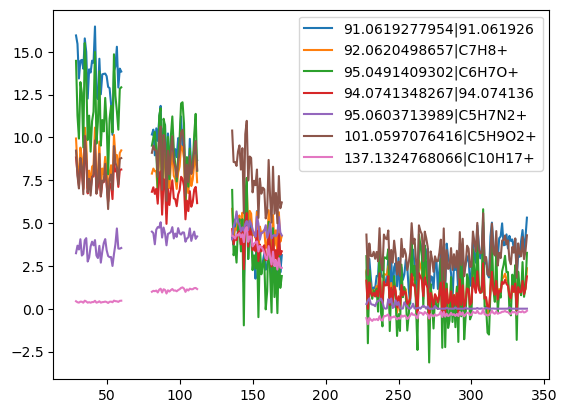

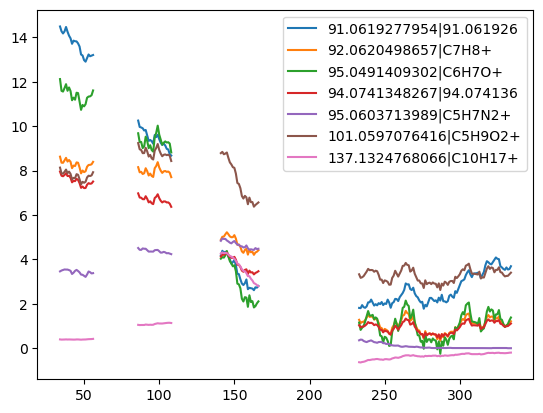

In [110]:
#Selecting specific columns based on highest signal for CxHyOz and CxHy compounds - Based of Shareen's filtering
selected_columns_O = [ '73.0284042358|C3H5O2+','95.0491409302|C6H7O+', '101.0597076416|C5H9O2+']  # Columns for CxHyOz compounds with highest signal
selected_columns_H = ['57.0704231262|C4H9', '65.0391235352|C5H5', '71.0860748291|C5H11', '91.0542297363|C7H7+', '92.0620498657|C7H8+'] # Columns for CxHy compounds with highest signal

normalized_O = corrected[selected_columns_O] # Filter total data set by specific CxHyOz compounds
normalized_H = corrected[selected_columns_H] # Filter total data set by specific CxHy compounds 

smoothed_normalized_O = normalized_O.rolling(window= 100, center=True).mean() # Smooth normalized_O over a 100 window
smoothed_normalized_H = normalized_H.rolling(window= 100, center=True).mean() # Smooth normalized_H over a 100 window

# print("Selected columns for CxHyOz compounds:", smoothed_normalized_O.head(20))
# print("Selected columns for CxHy compounds:", smoothed_normalized_H.head(20))

# '61.0284042358|C2H5O2+'

# Determining columns based on signal size
top20_cols = corrected.max().sort_values(ascending=False).head(20).index.tolist() # Find the top 20 columns with the highest maximum values in 'corrected'
print("Top 20 columns with highest maximums:", top20_cols)

top20_data = corrected[top20_cols]
top20_data_smoothed = top20_data.rolling(window=100, center=True).mean() # Smooth the top 20 columns over a 100 window


# Highest peaks from top20 search
Interesting = ['91.0619277954|91.061926', '92.0620498657|C7H8+', '95.0491409302|C6H7O+', '94.0741348267|94.074136', '95.0603713989|C5H7N2+', '101.0597076416|C5H9O2+', '137.1324768066|C10H17+', ]

interesting_data = corrected[Interesting]  # Filter total data set by specific Interesting compounds
smoothed_interesting_data = interesting_data.rolling(window=10, center=True).mean() # Smooth the interesting data over a 100 window
interesting_data = interesting_data.plot()  # Fill NaN values with 0 for plotting
smoothed_interesting_data.plot()

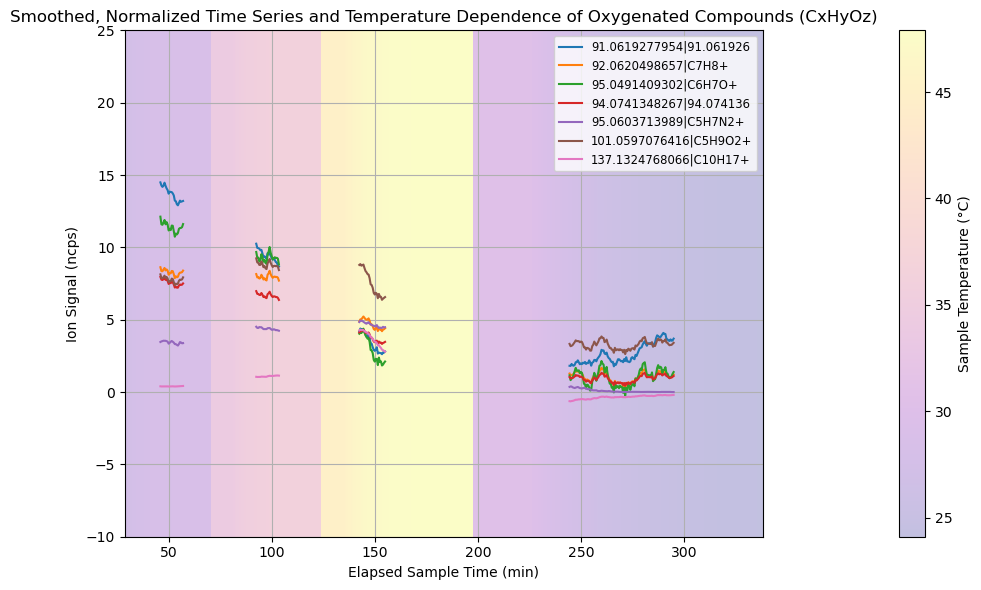

In [111]:
# Plotting CxHyOz Data (Normalized to H3O+, Acetone and backgrounded)
fig, ax = plt.subplots(figsize=(10, 6))

x = s_f_tseries['elapsed time (min)']

# Plot normalized O compounds
for col in smoothed_interesting_data.columns:
    ax.plot(x, smoothed_interesting_data[col], label=col)

ax.set_title('Smoothed, Normalized Time Series and Temperature Dependence of Oxygenated Compounds (CxHyOz)')
ax.set_xlabel('Elapsed Sample Time (min)')
ax.set_ylabel('Ion Signal (ncps)')
plt.ylim(-10, 25) 

# Plot temperature as a heatmap-style scatter on the same axis (no secondary y-axis)
temp_x = overlapping_intervals['elapsed time (min)'].values
temp_y = overlapping_intervals['sample temperature'].values

# Create a meshgrid for shading
X, Y = np.meshgrid(temp_x, ax.get_ylim())
Z = np.tile(temp_y, (2,1)).T  # shape: (len(temp_x), 2)
pcm = ax.pcolormesh(temp_x, ax.get_ylim(), np.array([temp_y, temp_y]), cmap='plasma', shading='auto', alpha=0.25)

# Add colorbar for temperature, explicitly passing the Axes
cbar = fig.colorbar(pcm, ax=ax, pad=0.15)
cbar.set_label('Sample Temperature (°C)')

# Legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper right', fontsize='small')

ax.grid(True)
fig.tight_layout()
plt.show()

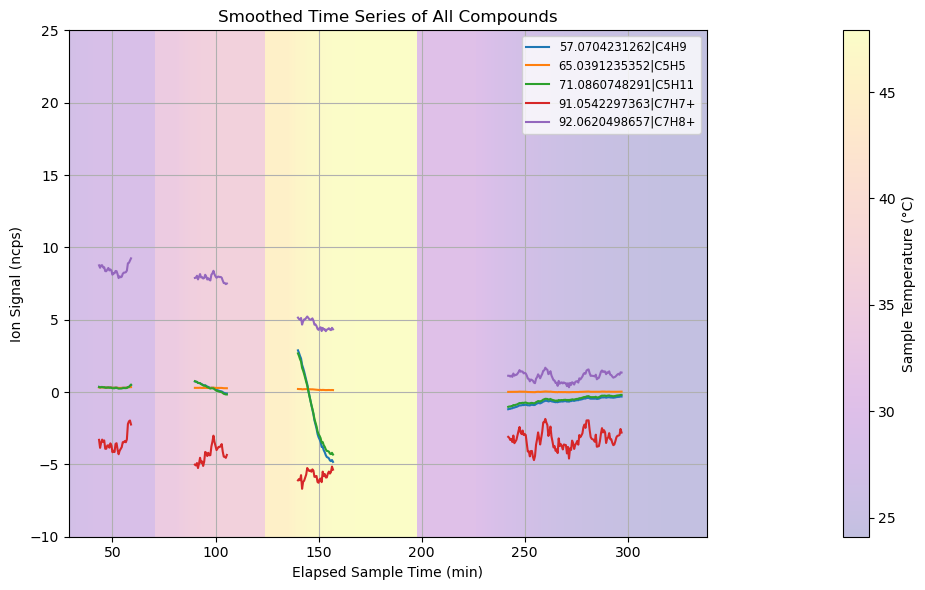

In [86]:
# Plotting CxHyOz Data (Normalized to H3O+ and backgrounded)
fig, ax = plt.subplots(figsize=(10, 6))

x = s_f_tseries['elapsed time (min)']

# Plot normalized H compounds
for col in smoothed_normalized_H.columns:
    ax.plot(x, smoothed_normalized_H[col], label=col)

ax.set_title('Smoothed Time Series of All Compounds')
ax.set_xlabel('Elapsed Sample Time (min)')
ax.set_ylabel('Ion Signal (ncps)')
plt.ylim(-10, 25) 

# Plot temperature as a heatmap-style scatter on the same axis (no secondary y-axis)
temp_x = overlapping_intervals['elapsed time (min)'].values
temp_y = overlapping_intervals['sample temperature'].values

# Create a meshgrid for shading
X, Y = np.meshgrid(temp_x, ax.get_ylim())
Z = np.tile(temp_y, (2,1)).T  # shape: (len(temp_x), 2)

pcm = ax.pcolormesh(temp_x, ax.get_ylim(), np.array([temp_y, temp_y]), cmap='plasma', shading='auto', alpha=0.25)

# Add colorbar for temperature, explicitly passing the Axes
cbar = fig.colorbar(pcm, ax=ax, pad=0.15)
cbar.set_label('Sample Temperature (°C)')

# Legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper right', fontsize='small')

ax.grid(True)
fig.tight_layout()
plt.show()

In [35]:
#Looking at the data in the specified time range for kinetic Analysis

# Identify range for t(0) and steady state analysis
start_time = pd.to_datetime('2025-06-05 01:08:15')
end_time = pd.to_datetime('2025-06-05 02:30:56')

# Filter the data for the specified time range
filter = (smoothed_normalized_O.index >= start_time) & (smoothed_normalized_O.index <= end_time)
data_O_range = smoothed_normalized_O[filter]
data_H_range = smoothed_normalized_H[filter]



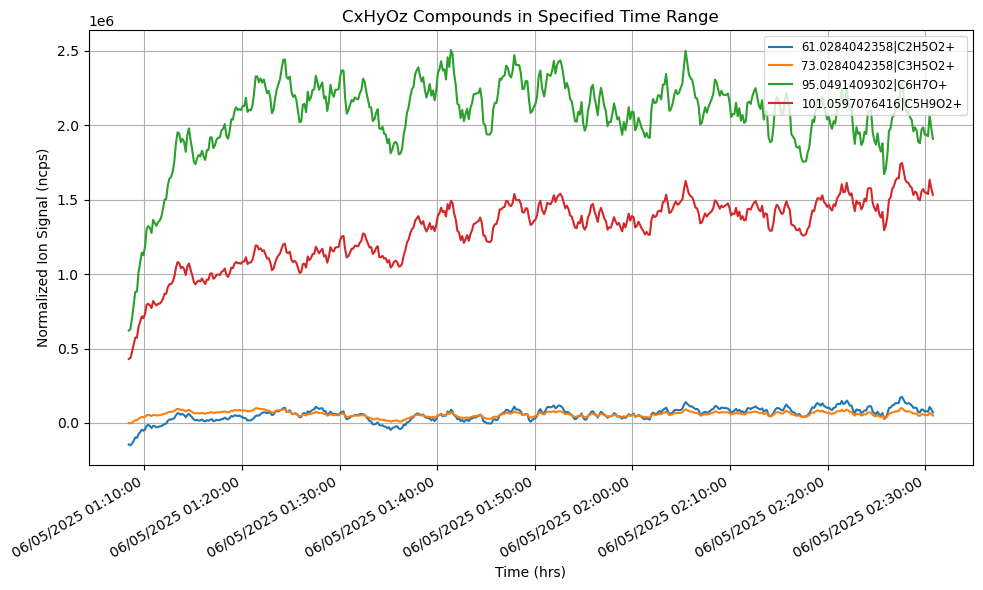

In [36]:
# Plot for CxHyOz compounds in the specified time range for kinetic analysis
plt.figure(figsize=(10, 6))
for col in data_O_range.columns:
    plt.plot(data_O_range.index, data_O_range[col], label=col)

# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.title('CxHyOz Compounds in Specified Time Range')
plt.xlabel('Time (hrs)')
plt.ylabel('Normalized Ion Signal (ncps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

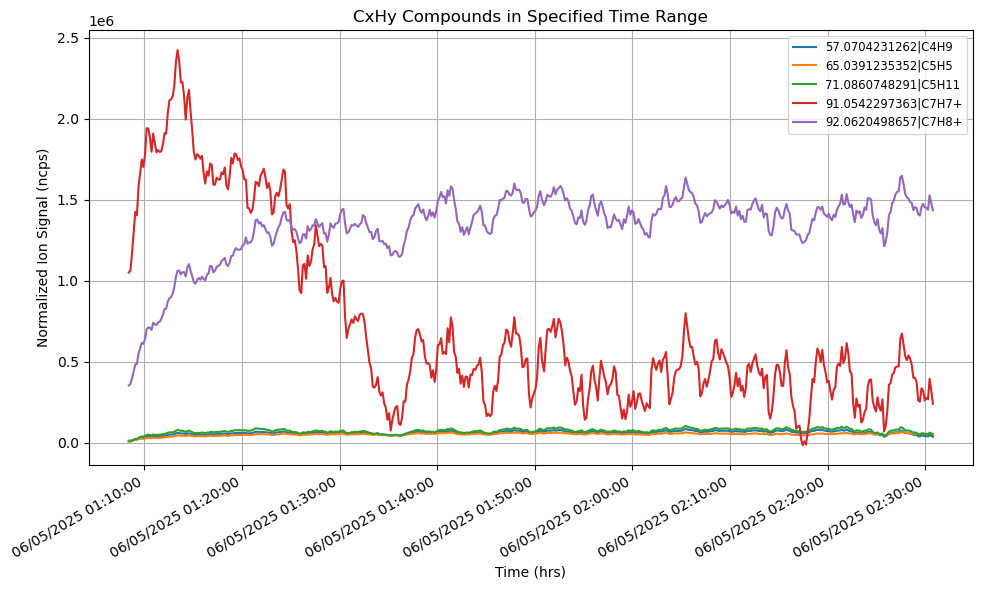

In [37]:
# Plot for CxHy compounds in the specified time range for kinetic analysis
plt.figure(figsize=(10, 6))
for col in data_H_range.columns:
    plt.plot(data_H_range.index, data_H_range[col], label=col)

# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.title('CxHy Compounds in Specified Time Range')
plt.xlabel('Time (hrs)')
plt.ylabel('Normalized Ion Signal (ncps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Lets do some kinetics - Define variables

#'A' = VOC you are studying above
A = '95.0491409302|C6H7O+' # Do this with cal gas (with sample)
Ag = data_O_range[A]  # Select the column for compound A from the filtered data (with sample)
Ag2 = data_O_range_ns[Ag] # KNOWN concentration of compound A as sampled by the vocus at a given time, gas phase (without sample), UNIT =


# Time 0 assumption to get ksup (with sample)
time_0_assumption = Ag.iloc[:3] # Get the values for the first 3 time steps from the filtered time series
time = time_0_assumption.index # Calculate time differences in seconds for the first 3 time steps
dt = (time[1:] - time[:-1]).total_seconds()  # array of time differences
dAg_dt = time_0_assumption.diff().iloc[1:] / dt  # # Calculate dAg/dt for the first 3 time steps
integrated_dAg_dt = np.trapz(dAg_dt, x=time[1:].astype('int64')/1e9)  # Integrate dAg/dt over the first 2 intervals (from t0 to t2) using the trapezoidal rule
print('Integrated dAg/dt from t0 to t2:', integrated_dAg_dt)    


# Time 0 assumption to get Kwdown (without sample)
time_0_assumption_ns = Ag2.iloc[:3] # Get the values for the first 3 time steps from the filtered time series
time = time_0_assumption_ns.index # Calculate time differences in seconds for the first 3 time steps
dt = (time[1:] - time[:-1]).total_seconds()  # array of time differences
dAg2_dt_0 = time_0_assumption_ns.diff().iloc[1:] / dt  # # Calculate dAg/dt for the first 3 time steps
integrated_dAg2_dt_0 = np.trapz(dAg2_dt_0, x=time[1:].astype('int64')/1e9)  # Integrate dAg2/dt over the first 2 intervals (from t0 to t2) using the trapezoidal rule
print('Integrated dAg2/dt from t0 to t2:', integrated_dAg2_dt_0)

# Steady State assumption of Ag with sample
start = pd.to_datetime('2025-06-05 01:40:00.') # Start time for steady state assumption
end = pd.to_datetime('2025-06-05 02:10:00') # End time for steady state assumption

Ag_ss = Ag[(Ag.index >= start) & (Ag.index <= end)] # Filter Ag for the specific time range
dAg_dt_ss = 0

# Steady State assumption of Ag2 without sample
Ag2_ss = Ag2[(Ag2.index >= start) & (Ag2.index <= end)] # Filter Ag2 for the specific time range
dAg2_dt_ss = 0

# Define variables (chamber WITHOUT sample)
V = 5361 # KNOWN Volume of canister, UNIT = L
SA2 = 41.3 # KNOWN Surface area of the cannister, UNIT = cm
C2 = time_0_assumption_ns.iloc[:3] # KNOWN Initial concentration of A at time 0, UNIT =
kdil = (400) / (V * 60) # rate of dilution, known from flow rate, UNIT = s-
kdilAg2 = kdil* Ag2 #rate and concentration of dilution of compound A, UNIT = s-
kwdownAg2 = integrated_dAg2_dt_0 / SA2 # Time zero assumption of d[Ag2]/dt, Ag2 concentration at time 0 = the total concentration and rate of A absorbing to the walls divided by the SA of the walls , UNIT =
kwdown = kwdownAg2 / Ag2 #rate of compound A absorbing to walls, UNIT = 

# Steady State assumption of d[Ag2]/dt allows us to solve for kwupAw, WITHOUT sample UNIT =
ksdown_Ag2_ss = kwdownAg2[(kwdownAg2.index >= start) & (kwdownAg2.index <= end)]
kdil_Ag2_ss = kdilAg2[(kdilAg2.index >= start) & (kdilAg2.index <= end)]
time_seconds = (Ag2_ss.index - Ag2_ss.index[0]).total_seconds()
kwdown_Ag2_integral = np.trapz(kwdownAg2, x=time_seconds) # Integrate each term over the time range
kdil_Ag2_integral = np.trapz(kdilAg2, x=time_seconds)
kwupAw_integral = kwdown_Ag2_integral + kdil_Ag2_integral # Steady State assumption of d[Ag2]/dt allows us to solve for kwupAw, UNIT =

Aw = C2 - Ag2_ss # Concentration of A on the walls, UNIT = 
kwup = kwupAw_integral/Aw # Rate of compound A emitting from the walls, UNIT = s-


# Define variables (chamber WITH sample)
S = 10.2 # KNOWN SA of sample, UNIT = cm
SA = SA2 - S # KNOWN surface area of the cannister - sample
Ag = data_O_range[A] # KNOWN concentration of compound A as sampled by the vocus, gas phase, UNIT = molecules/cm**3
C = time_0_assumption # Time zero assumption of d[As]/dt, Ag concentration at time 0 = the total concentration of compound A from the sample, UNIT = molecules/cm**3
kdilAg = kdil * Ag # rate and concentration of dilution of compound A, UNIT = s-
kwdownAg = (kwdown * Ag * SA2) / SA # rate and concentration of absorption to the walls divided by all of the wall, unit =
ksupAs = integrated_dAg_dt # Time zero assumption of d[Ag]/dt concentration and rate of compound A emitting from the sample, UNIT =


# Steady state assumption of d[Ag]/dt allows us to solve for ksdown WITH sample, unit = 
skdown_Ag_ss = kwdownAg[(kwdownAg.index >= start) & (kwdownAg.index <= end)]
kdil_Ag_ss = kdilAg[(kdilAg.index >= start) & (kdilAg.index <= end)]
time_seconds = (Ag_ss.index - Ag_ss.index[0]).total_seconds()
kwdown_Ag_integral = np.trapz(kwdownAg, x=time_seconds) # Integrate each term over the time range
kdil_Ag_integral = np.trapz(kdilAg, x=time_seconds)
ksdown_integral = kwdown_Ag_integral + kdil_Ag_integral # Steady State assumption of d[Ag2]/dt allows us to solve for kwupAw, UNIT =
ksdown = ksdown_integral / Ag # Rate of compound A absorption by sample, UNIT = s-

As = C - Ag - Aw # Concentration of compound A on the sample at a given time, UNIT = molecules/cm**3
ksup = ksupAs/As #4, rate for sample emission of compound A, UNIT = s-


NameError: name 'data_O_range_ns' is not defined

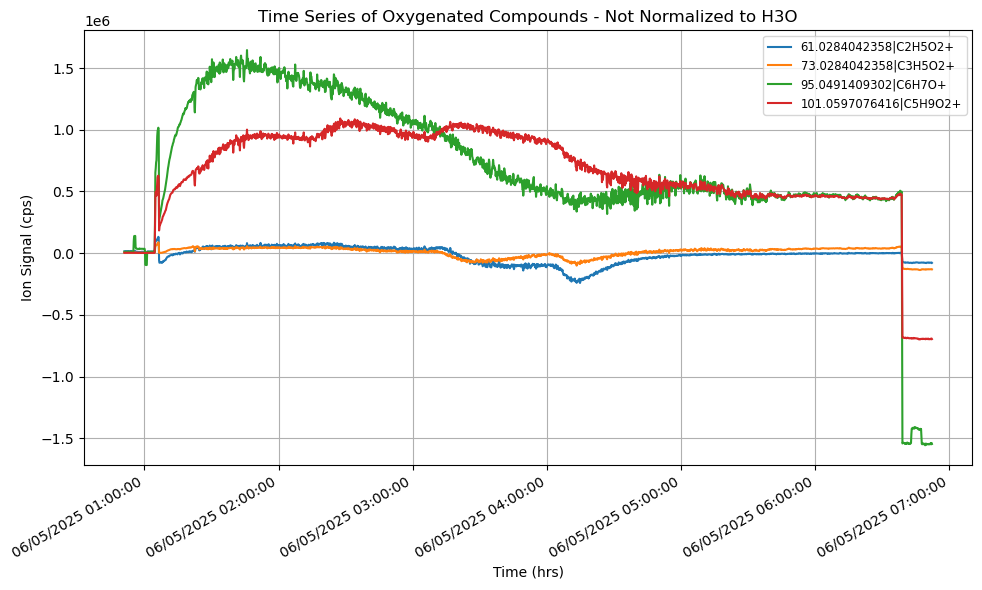

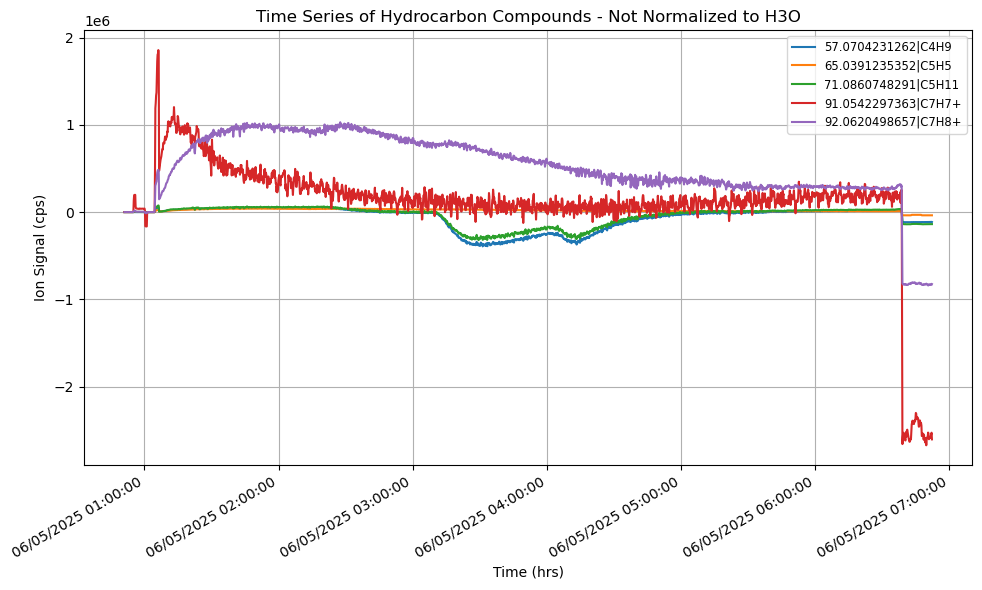

In [39]:
# TEST Taking tofwerk data and plotting it over time (WITH sample) - Not-Normalized

# Load the data
not_backgrounded_data = pd.read_csv('Raw_Mx_data.csv')
background_data = pd.read_csv('background_Mx_data_HR.csv')
data_time_series = pd.read_csv('all_tseries.csv')

# Background subtracted data
data = not_backgrounded_data - background_data

#Selecting specific columns based on highest signal for CxHyOz and CxHy compounds
selected_columns_O = ['61.0284042358|C2H5O2+', '73.0284042358|C3H5O2+','95.0491409302|C6H7O+', '101.0597076416|C5H9O2+']  # Columns for CxHyOz compounds with highest signal
selected_columns_H = ['57.0704231262|C4H9', '65.0391235352|C5H5', '71.0860748291|C5H11', '91.0542297363|C7H7+', '92.0620498657|C7H8+'] # Columns for CxHy compounds with highest signal

# Filter data
data_O = data[selected_columns_O] # Filter total data set by specific CxHyOz compounds
data_H = data[selected_columns_H] # Filter total data set by specific CxHy compounds  

# Convert time series to datetime format, make sure arrays are the same length
time = pd.to_datetime(data_time_series.iloc[:, 0])

min_len = min(len(time), len(data_O)) # Ensure all arrays are the same length
time_aligned = time[:min_len]
data_O_aligned = data_O.iloc[:min_len, :]
data_H_aligned = data_H.iloc[:min_len, :]

# Don't worry aout this
# '19.0178413391|H3O+', 
# '37.0289535522|H5O2', 

# Plot non-normalized data for CxHyOz compounds
plt.figure(figsize=(10, 6)) 
for col in data_O_aligned.columns: # Loop through each column in the data_O_aligned DataFrame
    plt.plot(time_aligned, data_O_aligned[col], label=col)

# Adjust x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.title('Time Series of Oxygenated Compounds - Not Normalized to H3O')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot non-normalized data for CxHy compounds
plt.figure(figsize=(10, 6)) 
for col in data_H_aligned.columns: # Loop through each column in the data_O_aligned DataFrame
    plt.plot(time_aligned, data_H_aligned[col], label=col)

# Adjust x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()

plt.title('Time Series of Hydrocarbon Compounds - Not Normalized to H3O')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

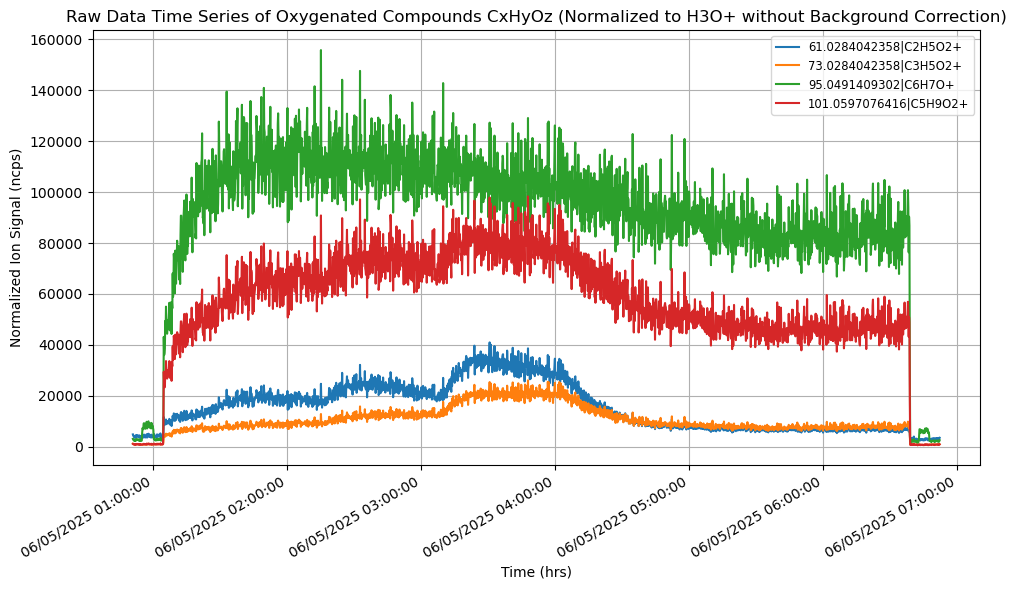

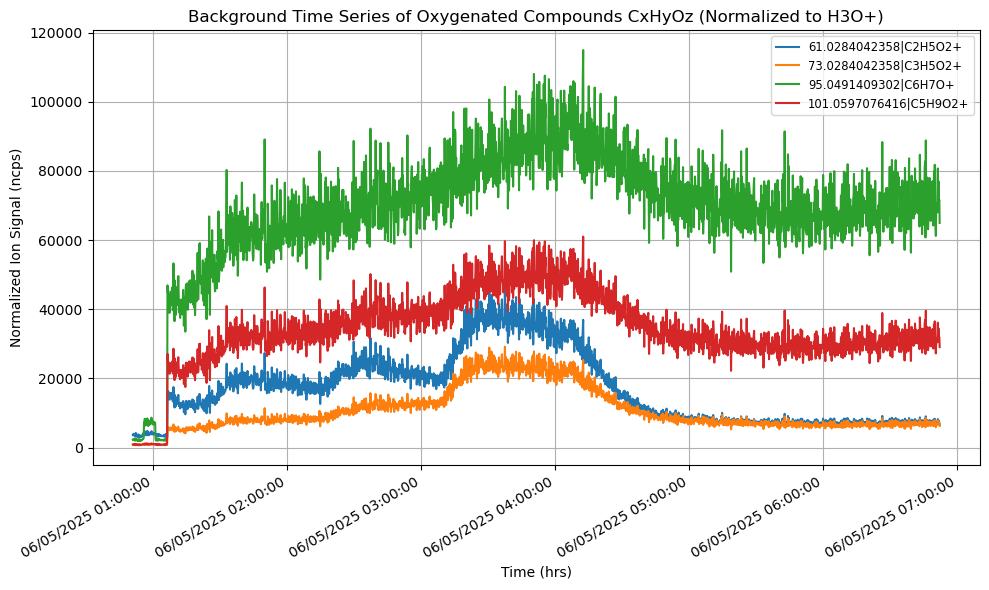

In [ ]:
# TEST Taking tofwerk data and plotting it over time (WITH sample) - Normalized to H3O+, NOT background corrected

# Load the data
data = pd.read_csv('Raw_Mx_data.csv') # data from tofwerk with sample
bg = pd.read_csv('background_Mx_data_HR.csv') # background data from tofwerk
time_df = pd.read_csv('all_tseries.csv')

time = pd.to_datetime(time_df.iloc[:, 0]) # Convert time series to datetime format, make sure arrays are the same length

# Ensure all dataframes are the same length
min_len = min(len(time), len(data_O)) # Ensure all arrays are the same length
n = min(len(data), len(bg), len(time))
data_aligned = data.iloc[:n].reset_index(drop=True)
bg_aligned = bg.iloc[:n].reset_index(drop=True)
time_aligned = time[:min_len]

# Normalize data to H3O+ without background correction
h3o = '19.0178413391|H3O+' # Identify H3O+ column

data_aligned = data_aligned.replace([np.inf, -np.inf], np.nan) # Replace NaNs with np.nan
bg_aligned = bg_aligned.replace([np.inf, -np.inf], np.nan) # Replace NaNs with np.nan

normalizer_data = data_aligned[h3o] # Select H3O+ column
normalizer_bg = bg_aligned[h3o] # Select H3O+ column for background

normalized_data = data_aligned.div(normalizer_data, axis=0) # Normalize all columns by H3O+
normalized_bg = bg_aligned.div(normalizer_bg, axis=0) # Normalize all columns by H3O+ for background

# Selecting specific columns based on highest signal for CxHyOz and CxHy compounds
selected_columns_O = ['61.0284042358|C2H5O2+', '73.0284042358|C3H5O2+','95.0491409302|C6H7O+', '101.0597076416|C5H9O2+']  # Columns for CxHyOz compounds with highest signal
selected_columns_H = ['57.0704231262|C4H9', '65.0391235352|C5H5', '71.0860748291|C5H11', '91.0542297363|C7H7+', '92.0620498657|C7H8+'] # Columns for CxHy compounds with highest signal

normalized_O_data = normalized_data[selected_columns_O] # Filter total data set by specific CxHyOz compounds
normalized_H_data = normalized_data[selected_columns_H] # Filter total data set by specific CxHy compounds

normalized_O_bg = normalized_bg[selected_columns_O] # Filter total data set by specific CxHyOz compounds for background
normalized_H_bg = normalized_bg[selected_columns_H] # Filter total data set by specific CxHy compounds for background

normalized_O_data.index = time_aligned # Set index to time_aligned
normalized_H_data.index = time_aligned 
normalized_O_bg.index = time_aligned 
normalized_H_bg.index = time_aligned

# TEST Plotting CxHyOz Data (Normalized to H3O+ without Background Correction)
plt.figure(figsize=(10, 6))
for col in normalized_O_data.columns:  # Loop through each column in the normalized_O_data DataFrame
    plt.plot(normalized_O_data.index, normalized_O_data[col], label=col)
# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()  
plt.title('Raw Data Time Series of Oxygenated Compounds CxHyOz (Normalized to H3O+ without Background Correction)')
plt.xlabel('Time (hrs)')
plt.ylabel('Normalized Ion Signal (ncps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CxHyOz Data (Normalized to H3O+ background data)
plt.figure(figsize=(10, 6))
for col in normalized_O_bg.columns:  # Loop through each column in the normalized_O_bg DataFrame
    plt.plot(normalized_O_bg.index, normalized_O_bg[col], label=col)
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.title('Background Time Series of Oxygenated Compounds CxHy (Normalized to H3O+  not background)')
plt.xlabel('Time (hrs)')
plt.ylabel('Normalized Ion Signal (ncps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()



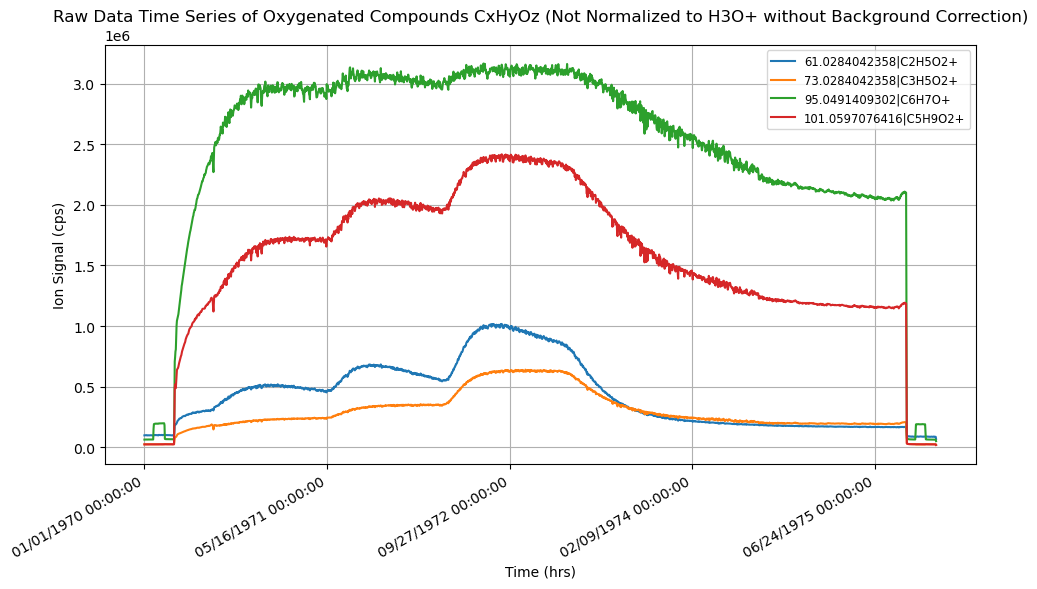

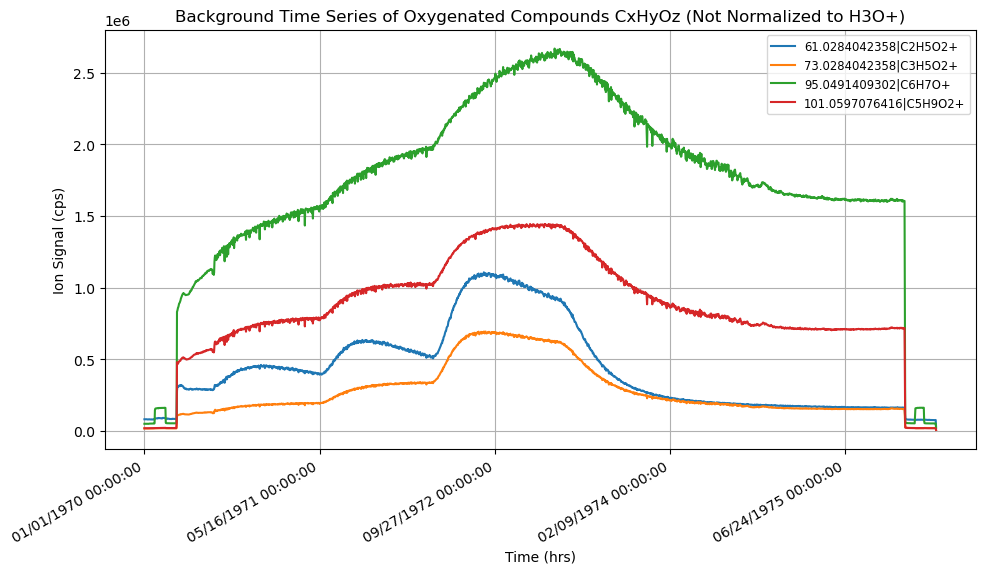

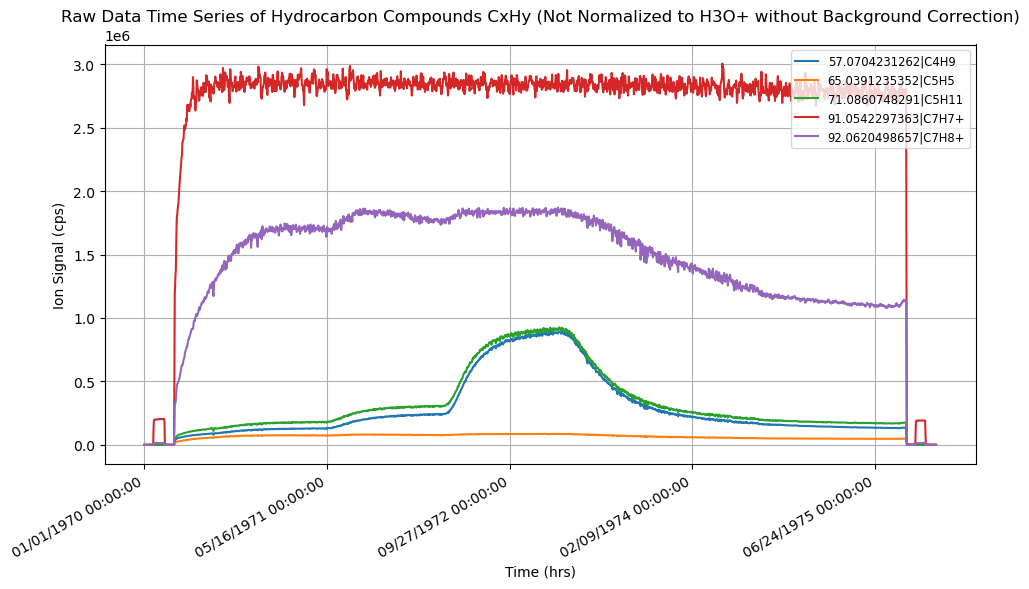

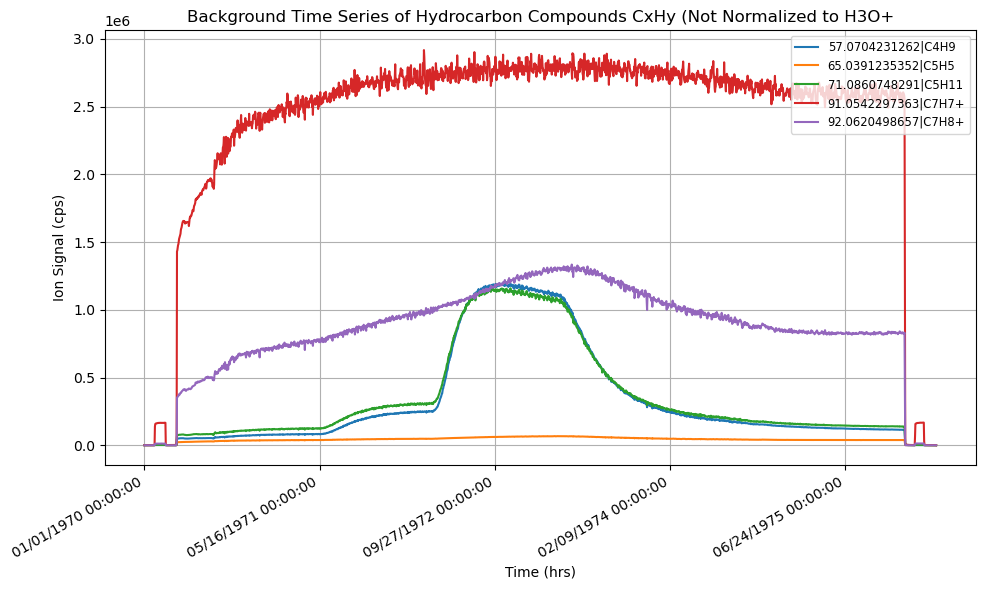

In [41]:
# TEST Taking tofwerk data and plotting it over time (WITH sample) - NOT Normalized to H3O+, NOT background corrected

# Load the data
data = pd.read_csv('Raw_Mx_data.csv') # data from tofwerk with sample
bg = pd.read_csv('background_Mx_data_HR.csv') # background data from tofwerk
time_df = pd.read_csv('all_tseries.csv')

time = pd.to_datetime(time_df.iloc[:, 0]) # Convert time series to datetime format, make sure arrays are the same length

# Ensure all dataframes are the same length
min_len = min(len(time), len(data), len(bg)) # Ensure all arrays are the same length
n = min(len(data), len(bg), len(time))
data_aligned = data.iloc[:n].reset_index(drop=True)
bg_aligned = bg.iloc[:n].reset_index(drop=True)
time_aligned = time[:min_len]

# Selecting specific columns based on highest signal for CxHyOz and CxHy compounds
selected_columns_O = ['61.0284042358|C2H5O2+', '73.0284042358|C3H5O2+','95.0491409302|C6H7O+', '101.0597076416|C5H9O2+']  # Columns for CxHyOz compounds with highest signal
selected_columns_H = ['57.0704231262|C4H9', '65.0391235352|C5H5', '71.0860748291|C5H11', '91.0542297363|C7H7+', '92.0620498657|C7H8+'] # Columns for CxHy compounds with highest signal

O_data = data[selected_columns_O] # Filter total data set by specific CxHyOz compounds
H_data = data[selected_columns_H] # Filter total data set by specific CxHy compounds

O_bg = bg[selected_columns_O] # Filter total data set by specific CxHyOz compounds for background
H_bg = bg[selected_columns_H] # Filter total data set by specific CxHy compounds for background


# Plotting CxHyOz Data (Normalized to H3O+ NOT background corrected)
plt.figure(figsize=(10, 6))
for col in O_data.columns:  # Loop through each column in the normalized_O_data DataFrame
    plt.plot(O_data.index, O_data[col], label=col) 
# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.title('Raw Data Time Series of Oxygenated Compounds CxHyOz (Not Normalized to H3O+ without Background Correction)')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)') 
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CxHyOz Data (Not Normalized to H3O+ background data)
plt.figure(figsize=(10, 6))
for col in O_bg.columns:  # Loop through each column in the normalized_O_bg DataFrame
    plt.plot(O_bg.index, O_bg[col], label=col)
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.title('Background Time Series of Oxygenated Compounds CxHyOz (Not Normalized to H3O+)')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CxHy Data (Not Normalized to H3O+ NOT background data)
plt.figure(figsize=(10, 6))
for col in H_data.columns:  # Loop through each column in the normalized_H_data DataFrame
    plt.plot(H_data.index, H_data[col], label=col, linewidth=1.5)
# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.title('Raw Data Time Series of Hydrocarbon Compounds CxHy (Not Normalized to H3O+ without Background Correction)')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting CxHy Data (Not Normalized to H3O+ background data)
plt.figure(figsize=(10, 6))
for col in H_bg.columns:  # Loop through each column in the normalized_H_bg DataFrame
    plt.plot(H_bg.index, H_bg[col], label=col, linewidth=1.5)
# Format x-axis to match time series .csv
date_format = mdates.DateFormatter('%m/%d/%Y %H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().autofmt_xdate()
plt.title('Background Time Series of Hydrocarbon Compounds CxHy (Not Normalized to H3O+')
plt.xlabel('Time (hrs)')
plt.ylabel('Ion Signal (cps)')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
# Calculate the change in concentration of VOC A for the first 5 time steps
# A is defined as '95.0491409302|C6H7O+' in cell 11
voc_A_col = '95.0491409302|C6H7O+'

# Get the values for the first 5 time steps from the filtered time series
a_values = data_O_range[voc_A_col].iloc[:5]

# Calculate the change (delta) between each time step
# This will give you the difference between consecutive time points
concentration_changes = a_values.diff().dropna()

print("VOC A concentrations (first 5 time steps):\n", a_values.values)
print("Change in concentration between time steps:\n", concentration_changes.values)

# Calculate and print the average change in concentration for the first 5 time steps
avg_change = concentration_changes.mean()
print("Average change in concentration (first 5 time steps):", avg_change)

VOC A concentrations (first 5 time steps):
 [ 910.5577542  2497.63272416 4517.80846405 5085.67460393 7386.04915963]
Change in concentration between time steps:
 [1587.07496996 2020.17573989  567.86613988 2300.3745557 ]


In [ ]:
# BINNING ATTEMPT Time Series, Bg versus Sample
temp_data = pd.read_csv('sample_TD.csv', encoding='utf-16', delimiter='\t')
temp_bg = pd.read_csv('bg_thermo_data.csv', encoding='utf-16', delimiter='\t')

temp_data = temp_data.rename(columns={'°C.1': 'Canister C'}) # renaming columns for ease
temp_bg = temp_bg.rename(columns={'°C.1': 'Canister C'})

temp_range_data = temp_data['Canister C'] # temperature range is just the internal canister temperature
temp_range_bg = temp_bg['Canister C']

time_range_data = temp_data['Time'] # Time range is just elapsed time
time_range_bg = temp_bg['Time']


# Plot Sample Canister C
plt.figure(figsize=(10, 5))
plt.plot(time_range_data, temp_range_data, color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Sample Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Background Canister C
plt.figure(figsize=(10, 5))
plt.plot(time_range_bg, temp_range_bg, color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Background Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# room temp - 28C time range
data_start_time = '18:05:59'
data_end_time = '19:22:59'
bg_start_time = '16:31:26'
bg_end_time = '17:51:26'

mask_data = (time_range_data >= data_start_time) & (time_range_data <= data_end_time) # Filter data for the specific time range
mask_bg = (time_range_bg >= bg_start_time) & (time_range_bg <= bg_end_time)

filtered_data = temp_data[mask_data]
filtered_bg = temp_bg[mask_bg]

'''
# Plot filtered sample data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data['Time'], filtered_data['Canister C'], color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Sample Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# Plot filtered background data
plt.figure(figsize=(10, 5))
plt.plot(filtered_bg['Time'], filtered_bg['Canister C'], color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Background Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
'''

# Get number of bins over filtered time frame to match by averaging the filtered_bg
n_target_1 = len(filtered_data['Time']) # Number of points you want

bg_values = filtered_bg['Canister C'].values
bg_binned = np.array_split(bg_values, n_target_1) # Split background data into n_target bins and average each bin
bg_avg = [np.mean(bin) for bin in bg_binned]

'''
# Use filtered_data['Time'] as the new time axis for the averaged background
plt.figure(figsize=(10, 5))
plt.plot(filtered_data['Time'], bg_avg, color='orange', linestyle='--', label='Averaged Background')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Averaged, range 1 Background Canister C Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

# 28 - 32C Time range
sample_time_range_2_start = ('19:16:26')
sample_time_range_2_end = ('20:09:29')
bg_time_range_2_start = ('17:44:26')
bg_time_range_2_end = ('18:38:26')

mask_data_2 = (time_range_data >= sample_time_range_2_start) & (time_range_data <= sample_time_range_2_end)
mask_bg_2 = (time_range_bg >= bg_time_range_2_start) & (time_range_bg <= bg_time_range_2_end)

filtered_data_2 = temp_data[mask_data_2]
filtered_bg_2 = temp_bg[mask_bg_2]

'''
# Plot filtered sample data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data_2['Time'], filtered_data_2['Canister C'], color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Range 2 Sample Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
'''
'''
# Plot filtered background data
plt.figure(figsize=(10, 5))
plt.plot(filtered_bg_2['Time'], filtered_bg_2['Canister C'], color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Range 2 Background Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
'''
print("Number of 30s bins in filtered_bg_2['Time_str']:", len(filtered_bg_2['Time']))
print("Number of time points in filtered_data_2['Time']:", len(filtered_data_2['Time']))

n_target_2 = len(filtered_data_2['Time'])

bg_values_2 = filtered_bg_2['Canister C'].values
bg_binned_2 = np.array_split(bg_values_2, n_target_2)
bg_avg_2 = [np.mean(bin) for bin in bg_binned_2]

'''
# Use filtered_data['Time'] as the new time axis for the averaged background
plt.figure(figsize=(10, 5))
plt.plot(filtered_data_2['Time'], bg_avg_2, color='orange', linestyle='--', label='Averaged Background')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Averaged, range 2 Background Canister C Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

# 32-37C Time range
sample_time_range_3_start = ('20:09:29')
sample_time_range_3_end = ('21:02:59')
bg_time_range_3_start = ('18:38:26')
bg_time_range_3_end = ('19:31:26')

mask_data_3 = (time_range_data >= sample_time_range_3_start) & (time_range_data <= sample_time_range_3_end)
mask_bg_3 = (time_range_bg >= bg_time_range_3_start) & (time_range_bg <= bg_time_range_3_end)

filtered_data_3 = temp_data[mask_data_3]
filtered_bg_3 = temp_bg[mask_bg_3]

'''
# Plot filtered sample data
plt.figure(figsize=(10, 5))
plt.plot(filtered_data_3['Time'], filtered_data_3['Canister C'], color='blue')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Range 3 Sample Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot filtered background data
plt.figure(figsize=(10, 5))
plt.plot(filtered_bg_3['Time'], filtered_bg_3['Canister C'], color='orange', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Filtered Range 3 Background Canister C Temperature')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
'''
print("Number of 30s bins in filtered_bg_3['Time']:", len(filtered_bg_3['Time']))
print("Number of time points in filtered_data_3['Time']:", len(filtered_data_3['Time']))

n_target_3 = len(filtered_bg_3['Time'])
data_values_3 = filtered_data_3['Canister C'].values
data_binned_3 = np.array_split(data_values_3, n_target_3)
data_avg_3 = [np.mean(bin) for bin in data_binned_3]

# 37C to cool off time range
sample_time_range_4_start = ('21:02:59')
sample_time_range_4_end = ('23:47:59')
bg_time_range_4_start = ('19:31:26')
bg_time_range_4_end = ('22:22:26')

mask_data_4 = (time_range_data >= sample_time_range_4_start) & (time_range_data <= sample_time_range_4_end)
mask_bg_4 = (time_range_bg >= bg_time_range_4_start) & (time_range_bg <= bg_time_range_4_end)

filtered_data_4 = temp_data[mask_data_4]
filtered_bg_4 = temp_bg[mask_bg_4]

print("Number of 30s bins in filtered_bg_4['Time']:", len(filtered_bg_4['Time']))
print("Number of time points in filtered_data_4['Time']:", len(filtered_data_4['Time']))

n_target_4 = len(filtered_bg_4['Time'])

data_values_4 = filtered_data_4['Canister C'].values 
data_binned_4 = np.array_split(data_values_4, n_target_4)
data_avg_4 = [np.mean(bin) for bin in data_binned_4]
'''
# Use filtered_data['Time'] as the new time axis for the averaged background
plt.figure(figsize=(10, 5))
plt.plot(filtered_bg_3['Time'], data_avg_3, color='orange', linestyle='--', label='Averaged Background')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.title('Averaged, range 3 Background Canister C Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
'''

# Get number of points over total time frame
data_avg_3_series = pd.Series(data_avg_3, name='Canister C') # Get into correct format
bg_avg_series = pd.Series(bg_avg, name='Canister C') # Get into correct format
bg_avg_2_series = pd.Series(bg_avg_2, name='Canister C') # Get into correct format
bg_avg_4_series = pd.Series(filtered_bg_4['Canister C'].values, name='Canister C') # Get into correct format

all_times = pd.concat([filtered_data['Time'], filtered_data_2['Time'], filtered_data_3['Time'], filtered_data_4['Time']], ignore_index=True) # combine time ranges
data_temps = pd.concat([filtered_data['Canister C'], filtered_data_2['Canister C'], data_avg_3_series, filtered_data_4['Canister C']], ignore_index=True) # combine data temperature ranges
bg_temps = pd.concat([bg_avg_series, bg_avg_2_series, filtered_bg_3['Canister C'], bg_avg_4_series], ignore_index=True) # combine background temperature ranges

subtract_temps = data_temps - bg_temps # get background corrected temperature

thermocouple_df = pd.DataFrame({'time': all_times,'data temperature': data_temps,'bg temperature': bg_temps,'background corrected temperature': subtract_temps}) # Create a new DataFrame

thermocouple_df.to_csv('Canister_temp_vs_time.csv', index=False) # make .csv
thermocouple_df['elapsed time (min)'] = np.arange(len(thermocouple_df['time'])) * 30 / 60  # increases by 30 seconds, in minutes
thermocouple_df.to_csv('Canister_temp_vs_time.csv', index=False) # add to .csv
print(thermocouple_df.head(20))

plt.figure(figsize=(12, 6))
plt.plot(thermocouple_df['elapsed time (min)'], thermocouple_df['data temperature'], label='Data Temperature', color='blue')
plt.plot(thermocouple_df['elapsed time (min)'], thermocouple_df['bg temperature'], label='Background Temperature', color='orange', linestyle='--')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Thermocoupled Data vs Background Temperature')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Average change in concentration (first 5 time steps): 1618.8728513576189


In [ ]:
# Have time series from the sample and bg runs match the thermocouple time series using binning

# Load time series data
v_sample_time = pd.read_csv('sample_tseries.csv', delimiter=' ',  names=['vocus time'], header=None)
v_bg_time = pd.read_csv('background_tseries.csv', delimiter=' ',  names=['vocus time'], header=None)

TC_time_series = pd.read_csv('Canister_temp_vs_time.csv') # Time series from thermocouple
bg = pd.read_csv('background_Mx_data_HR.csv') # background data from tofwerk
data = pd.read_csv('Raw_Mx_data.csv') # sample data from tofwerk

# Convert vocus sample and bg data to 30s intervals like the thermocuple data
v_sample_time = v_sample_time.reset_index(drop=True) # numeric index
v_sample_time['vocus time'] = pd.to_datetime(v_sample_time['vocus time'], errors='coerce') # Make datetime
v_sample_time['30s time average'] = (v_sample_time.groupby(v_sample_time.index // 3)['vocus time'].agg('mean')) # add new column: mean of vocus time every 3 rows
v_sample_time['elapsed time (min)'] = np.arange(len(v_sample_time['30s time average'])) * 30 / 60  # increases by 30 seconds, in minutes

v_bg_time = v_bg_time.reset_index(drop=True) # numeric index
v_bg_time['vocus time'] = pd.to_datetime(v_bg_time['vocus time'], errors='coerce')
v_bg_time['30s time average'] = (v_bg_time.groupby(v_bg_time.index // 3)['vocus time'].agg('mean')) # add new column: mean of vocus time every 3 rows
v_bg_time['elapsed time (min)'] = np.arange(len(v_bg_time['30s time average'])) * 30 / 60  # increases by 30 seconds, in minutes


# Match v_sample_time and v_bg_time to thermocouple time series
n_target_vocus = len(TC_time_series['elapsed time (min)']) # get target length = TC every 30s

v_bg_values = v_bg_time['30s time average'].values
binned_bg = np.array_split(v_bg_values, n_target_vocus)
avg_bg_time = [pd.Series(bin).mean() for bin in binned_bg]

v_s_values = v_sample_time['30s time average'].values
binned_s = np.array_split(v_s_values, n_target_vocus)
avg_s_time = [pd.Series(bin).mean() for bin in binned_s]

print(len(avg_bg_time))
print(len(avg_s_time))
print(len(TC_time_series['elapsed time (min)']))


# bin bg and data to match TC time series
n_target = len(TC_time_series['elapsed time (min)']) # same target length for bg and data

bg_binned_vocus = [] # Bin and average each column in bg to match n_target rows
for col in bg.columns:
    col_values = bg[col].values
    bins = np.array_split(col_values, n_target)
    avg_col = [np.mean(bin) for bin in bins]
    bg_binned_vocus.append(avg_col)

bg_avg_data = pd.DataFrame(np.array(bg_binned_vocus).T, columns=bg.columns) # Create new DataFrame with averaged column
bg_avg_data.to_csv('background_Mx_data_HR_binned.csv', index=False) # Save as a .csv

print(bg_avg_data.head(20)) # Print first 20 rows of the new background data
print(len(bg_avg_data))

sample_binned_vocus = [] # Bin and average each column in sample to match n_target rows
for col in data.columns:
    col_values = data[col].values
    bins = np.array_split(col_values, n_target)
    avg_col = [np.mean(bin) for bin in bins]
    sample_binned_vocus.append(avg_col)

sample_avg_data = pd.DataFrame(np.array(sample_binned_vocus).T, columns=data.columns) # Create new DataFrame with averaged column
sample_avg_data.to_csv('sample_Mx_data_HR_binned.csv', index=False) # Save as a .csv

print(sample_avg_data.head(20)) # Print first 20 rows of the new sample data
print(len(sample_avg_data))

In [ ]:
# Time series analysis using interpolation
temp_data = pd.read_csv('sample_TD.csv', encoding='utf-16', delimiter='\t')
temp_bg = pd.read_csv('bg_thermo_data.csv', encoding='utf-16', delimiter='\t')

temp_data = temp_data.rename(columns={'°C.1': 'Canister C'}) # renaming columns for ease
temp_bg = temp_bg.rename(columns={'°C.1': 'Canister C'})

# temp_range_data = temp_data['Canister C'] # temperature range is just the internal canister temperature
# temp_range_bg = temp_bg['Canister C']

temp_data['elapsed time (min)'] = np.arange(len(temp_data['Time'])) * 30 / 60  # increases by 30 seconds, in minutes
temp_bg['elapsed time (min)'] = np.arange(len(temp_bg['Time'])) * 30 / 60  # increases by 30 seconds, in minutes

# time_range_data = temp_data['elapsed time (min)'] # select Time range (elapsed time)
# time_range_bg = temp_bg['elapsed time (min)']

#Time range 1 room temperature to 28C 
data_start_str = '18:5:59'
data_end_str = '19:15:29'
bg_start_str = '16:31:26'
bg_end_str = '17:43:26'

data_start_min = temp_data.loc[temp_data['Time'] == data_start_str, 'elapsed time (min)'].iloc[0] # Find the corresponding elapsed time in minutes for the start/end times
data_end_min = temp_data.loc[temp_data['Time'] == data_end_str, 'elapsed time (min)'].iloc[0]
bg_start_min = temp_bg.loc[temp_bg['Time'] == bg_start_str, 'elapsed time (min)'].iloc[0]
bg_end_min = temp_bg.loc[temp_bg['Time'] == bg_end_str, 'elapsed time (min)'].iloc[0]

filtered_data = temp_data[(temp_data['elapsed time (min)'] >= data_start_min) & (temp_data['elapsed time (min)'] <= data_end_min)] # Filter both dataframes using the elapsed time in minutes
filtered_bg = temp_bg[(temp_bg['elapsed time (min)'] >= bg_start_min) & (temp_bg['elapsed time (min)'] <= bg_end_min)]

interp_data_temps = np.interp(filtered_bg['elapsed time (min)'], filtered_data['elapsed time (min)'], filtered_data['Canister C']) # Interpolate the sample data (temp_data) to the background's elapsed time points

plt.figure(figsize=(12, 6))
plt.plot(filtered_bg['elapsed time (min)'], filtered_bg['Canister C'], label='Background Temperature', color='orange', linestyle='--')
plt.plot(filtered_bg['elapsed time (min)'], interp_data_temps, label='Sample Temperature (Interpolated)', color='blue')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Background vs. Interpolated Sample Temperature (Time Range 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 28C to 32C time range
sample_time_range_2_start = '19:15:29'
sample_time_range_2_end = '20:9:29'
bg_time_range_2_start = '17:43:26'
bg_time_range_2_end = '18:36:56'

# Find the corresponding elapsed time in minutes for the start/end times
data_start_min_2 = temp_data.loc[temp_data['Time'] == sample_time_range_2_start, 'elapsed time (min)'].iloc[0]
data_end_min_2 = temp_data.loc[temp_data['Time'] == sample_time_range_2_end, 'elapsed time (min)'].iloc[0]
bg_start_min_2 = temp_bg.loc[temp_bg['Time'] == bg_time_range_2_start, 'elapsed time (min)'].iloc[0]
bg_end_min_2 = temp_bg.loc[temp_bg['Time'] == bg_time_range_2_end, 'elapsed time (min)'].iloc[0]

# Filter both dataframes using the elapsed time in minutes for the second time range
filtered_data_2 = temp_data[(temp_data['elapsed time (min)'] >= data_start_min_2) & (temp_data['elapsed time (min)'] <= data_end_min_2)]
filtered_bg_2 = temp_bg[(temp_bg['elapsed time (min)'] >= bg_start_min_2) & (temp_bg['elapsed time (min)'] <= bg_end_min_2)]

# Interpolate the sample data for the second time range
interp_data_temps_2 = np.interp(filtered_bg_2['elapsed time (min)'], filtered_data_2['elapsed time (min)'], filtered_data_2['Canister C'])

plt.figure(figsize=(12, 6))
plt.plot(filtered_bg_2['elapsed time (min)'], filtered_bg_2['Canister C'], label='Background Temperature', color='orange', linestyle='--')
plt.plot(filtered_bg_2['elapsed time (min)'], interp_data_temps_2, label='Sample Temperature (Interpolated)', color='blue')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Background vs. Interpolated Sample Temperature (Time Range 2: 32C-36C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 36C to 47C time range
sample_time_range_3_start = '20:9:29'
sample_time_range_3_end = '21:2:59'
bg_time_range_3_start = '18:36:56'
bg_time_range_3_end = '19:31:26'

data_start_min_3 = temp_data.loc[temp_data['Time'] == sample_time_range_2_start, 'elapsed time (min)'].iloc[0]
data_end_min_3 = temp_data.loc[temp_data['Time'] == sample_time_range_3_end, 'elapsed time (min)'].iloc[0]
bg_start_min_3 = temp_bg.loc[temp_bg['Time'] == bg_time_range_3_start, 'elapsed time (min)'].iloc[0]
bg_end_min_3 = temp_bg.loc[temp_bg['Time'] == bg_time_range_3_end, 'elapsed time (min)'].iloc[0]

filtered_data_3 = temp_data[(temp_data['elapsed time (min)'] >= data_start_min_3) & (temp_data['elapsed time (min)'] <= data_end_min_3)]
filtered_bg_3 = temp_bg[(temp_bg['elapsed time (min)'] >= bg_start_min_3) & (temp_bg['elapsed time (min)'] <= bg_end_min_3)]

interp_data_temps_3 = np.interp(filtered_bg_3['elapsed time (min)'], filtered_data_3['elapsed time (min)'], filtered_data_3['Canister C'])

plt.figure(figsize=(12, 6))
plt.plot(filtered_bg_3['elapsed time (min)'], filtered_bg_3['Canister C'], label='Background Temperature', color='orange', linestyle='--')
plt.plot(filtered_bg_3['elapsed time (min)'], interp_data_temps_3, label='Sample Temperature (Interpolated)', color='blue')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Background vs. Interpolated Sample Temperature (Time Range 3: 36C-47C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 37C to room temperature time range
sample_time_range_4_start = ('21:2:59')
sample_time_range_4_end = ('23:47:59')
bg_time_range_4_start = ('19:31:26')
bg_time_range_4_end = ('22:22:26')

data_start_min_4 = temp_data.loc[temp_data['Time'] == sample_time_range_4_start, 'elapsed time (min)'].iloc[0]
data_end_min_4 = temp_data.loc[temp_data['Time'] == sample_time_range_4_end, 'elapsed time (min)'].iloc[0]
bg_start_min_4 = temp_bg.loc[temp_bg['Time'] == bg_time_range_4_start, 'elapsed time (min)'].iloc[0]
bg_end_min_4 = temp_bg.loc[temp_bg['Time'] == bg_time_range_4_end, 'elapsed time (min)'].iloc[0]

filtered_data_4 = temp_data[(temp_data['elapsed time (min)'] >= data_start_min_4) & (temp_data['elapsed time (min)'] <= data_end_min_4)]
filtered_bg_4 = temp_bg[(temp_bg['elapsed time (min)'] >= bg_start_min_4) & (temp_bg['elapsed time (min)'] <= bg_end_min_4)]

interp_data_temps_4 = np.interp(filtered_bg_4['elapsed time (min)'], filtered_data_4['elapsed time (min)'], filtered_data_4['Canister C'])

# Plotting for Time Range 4
plt.figure(figsize=(12, 6))
plt.plot(filtered_bg_4['elapsed time (min)'], filtered_bg_4['Canister C'], label='Background Temperature', color='orange', linestyle='--')
plt.plot(filtered_bg_4['elapsed time (min)'], interp_data_temps_4, label='Sample Temperature (Interpolated)', color='blue')
plt.xlabel('Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Background vs. Interpolated Sample Temperature (Time Range 4: 37C-Room Temperature)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Temperature vs. time series across all time ranges
df1 = pd.DataFrame({'elapsed time (min)': filtered_bg['elapsed time (min)'],'background temperature C': filtered_bg['Canister C'],'Sample Temperature': interp_data_temps})
df2 = pd.DataFrame({'elapsed time (min)': filtered_bg_2['elapsed time (min)'],'background temperature C': filtered_bg_2['Canister C'],'Sample Temperature': interp_data_temps_2})
df3 = pd.DataFrame({'elapsed time (min)': filtered_bg_3['elapsed time (min)'],'background temperature C': filtered_bg_3['Canister C'],'Sample Temperature': interp_data_temps_3})
df4 = pd.DataFrame({'elapsed time (min)': filtered_bg_4['elapsed time (min)'], 'background temperature C': filtered_bg_4['Canister C'],'Sample Temperature': interp_data_temps_4})

tc_interpolated_tseries_df = pd.concat([df1, df2, df3, df4], ignore_index=True) # Concatenate all DataFrames
tc_interpolated_tseries_df.to_csv('TC_interpolated_tseries.csv', index=False) # Save to CSV

print(tc_interpolated_tseries_df.head())

plt.figure(figsize=(12, 6))
plt.plot(tc_interpolated_tseries_df['elapsed time (min)'], tc_interpolated_tseries_df['background temperature C'], label='Background Temperature', color='orange', linestyle='--')
plt.plot(tc_interpolated_tseries_df['elapsed time (min)'], tc_interpolated_tseries_df['Sample Temperature'], label='Sample Temperature', color='blue')
plt.xlabel('Total Elapsed Time (min)')
plt.ylabel('Temperature (°C)')
plt.title('Total Sample vs. Background Temperature Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Have Thermocouple and Vocus Time series data match using interpolation

# Load vocus data
v_sample_time = pd.read_csv('sample_tseries.csv', delimiter=' ',  names=['vocus time'], header=None)
v_bg_time = pd.read_csv('background_tseries.csv', delimiter=' ',  names=['vocus time'], header=None)

TC_time_series = pd.read_csv('TC_interpolated_tseries.csv') # Time series from thermocouple
bg = pd.read_csv('background_Mx_data_HR.csv') # background data from tofwerk
data = pd.read_csv('Raw_Mx_data.csv') # sample data from tofwerk

# Convert vocus sample and bg data to 30s intervals like the thermocuple data


print(v_bg_time.head(5))
print(v_sample_time.head(5))
print(f'bg vocus time = {len(v_bg_time["vocus time"])}')
print(f'bg elapsed time = {len(v_bg_time["elapsed time (min)"])}')
print(f'bg 30s time series = {len(v_bg_time["30s time average"])}')
print(f'vocus sample time = {len(v_sample_time["vocus time"])}')
print(f'sample elapsed time = {len(v_sample_time["elapsed time (min)"])}')
print(f'sample 30s time series = {len(v_sample_time["30s time average"])}')
print(f'TC elapsed time = {len(TC_time_series["elapsed time (min)"])}')